# Fire Risk Mapping Introductory Notebook

This example shows methods to process and visualize spatial aggregates of fire index and human built up areas. We will use data from the CA Fire and Rescue Assessment program for fire risk, county and city administrative regions datasets and the building construction change detection analytic reults to overlay human activity in areas of high fire risk

In [42]:
import requests
import os
import json
import pandas as pd
import geopandas as gpd
from h3 import h3
from pprint import pprint
import csv
from math import sqrt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

import folium
import webbrowser
from folium import Map
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse

## Accessing CAL Fire data

California Fires related data sources are aggregated at:
https://libguides.csun.edu/gis/california

CAL FIRE Fire and Resource Assessment Program (FRAP)
https://frap.fire.ca.gov/mapping/gis-data/

This report gives details on the metrics used to compute the risk index [0-5]
https://frap.fire.ca.gov/media/3180/assessment2017.pdf

FRAP gives us a statewide GIS layer in raster format of fire threat, which combines expected fire frequency with potential fire behavior to create 4 threat classes (v14_2 at fthrt14_2.zip). Converted this data from arcGIS data tables (gdbtables) to GEOTIFF and then used the QGIS zonal stats processing toolbox to get to the firethreat data set as GeoJSON.

Identifying data locations relative to the notebook location. 

In [43]:
SUB_ID_CA = '0163608e-0afb-477e-a500-3a87819351a1'
SUBSCRIPTION_ID = SUB_ID_CA

root_folder = './data/'
fire_threat_geojson = root_folder + 'CA-county_boundaries_firethreat.geojson'
subscription_geojson = root_folder + 'collection_0163608e-0afb-477e-a500-3a87819351a1.geojson'
city_geojson = root_folder + 'santa_clarita_city.geojson'

## Pulib Fire Risk Data Load and Prep

We load county with fire threat into polgyons into a geopandas dataframe. The risk data converts the 6 integer classes [0, 5] to the range [0.0, 128.0] after computing zonal stats

In [135]:
with open(fire_threat_geojson,  encoding = "ISO-8859-1") as f:
    study_area = json.load(f)
gdf = gpd.GeoDataFrame.from_features(study_area["features"])
gdf.shape

gdf.rename(columns={'_mean':'AV_FIRE_THREAT'}, inplace=True)
gdf['AV_FIRE_THREAT'] = gdf['AV_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_max':'MAX_FIRE_THREAT'}, inplace=True)
gdf['MAX_FIRE_THREAT'] = gdf['MAX_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_range':'RANGE_FIRE_THREAT'}, inplace=True)
gdf['RANGE_FIRE_THREAT'] = gdf['RANGE_FIRE_THREAT'].apply(lambda x: x/128.0)
gdf.rename(columns={'_variance':'STDDEV_FIRE_THREAT'}, inplace=True)
gdf['STDDEV_FIRE_THREAT'] = gdf['STDDEV_FIRE_THREAT'].apply(lambda x: sqrt(x)/128.0)

Let's take a look at what columns exits in this dataframe

In [136]:
gdf.iloc[0]

geometry              POLYGON ((-120.995497 38.225405, -121.027084 3...
GEO_ID                                                   0500000US06005
STATE                                                                06
COUNTY                                                              005
NAME                                                             Amador
LSAD                                                             County
CENSUSAREA                                                      594.583
_count                                                      1.78374e+06
_sum                                                        3.00083e+07
AV_FIRE_THREAT                                                 0.131431
MAX_FIRE_THREAT                                                       1
RANGE_FIRE_THREAT                                              0.992188
STDDEV_FIRE_THREAT                                             0.303902
Name: 0, dtype: object

## State Level Risk Profile

We now want to see the fire risk profile looks like across the State of CA and where the hotspots of fire risk are. Since we did the zonal stats based on county boundaries, we will have aggregated risk granularity at county level. We are going to use folium for spatial visualization. We are going to create two switchable folium layers, one for average risk and risk variability at one sigma so that we can have a holistic view into spatial fire risk data. One of the limitations of folium in a jupyter notebook is that you might get an IOPub data rate error if you try to load up too many geometries. You can change your IOPub data rate, or you can simply load up less data by simplifying the geometries. 

In [137]:
def folium_multilayer_risk_map(gdf):

    gdf['geometry'] = gdf['geometry'].simplify(0.001, preserve_topology=True)

    centroid=gdf.geometry.centroid[1]

    m = folium.Map([centroid.y, centroid.x], zoom_start=5, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['AV_FIRE_THREAT']])

    from branca.colormap import linear
    colormap = linear.YlOrRd_09.scale(df.AV_FIRE_THREAT.min(),df.AV_FIRE_THREAT.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        name="Average Fire Risk",
        style_function=lambda feature: {
            'fillColor': color_dict[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Average Risk'
    colormap.add_to(m)

    df=pd.DataFrame(gdf.loc[:,['STDDEV_FIRE_THREAT']])

    from branca.colormap import linear
    colormap = linear.RdPu_09.scale(df.STDDEV_FIRE_THREAT.min(),df.STDDEV_FIRE_THREAT.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict_dev = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        name="Risk Variability",
        style_function=lambda feature: {
            'fillColor': color_dict_dev[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Risk Variability'
    colormap.add_to(m)

    folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

    return m

folium_multilayer_risk_map(gdf)

## Zoning in on Los Angeles County

We notice that zones of high risk are also prone to high spatial varaibility. Areas near Central Valley have medium risk but also high variability owing to a predominantly grassland ecoregion. More at: https://www.worldwildlife.org/ecoregions/na0801

Let's now zone in our exploration and look more closely at the region near Castaic near the city of Santa Clarita in Los Angeles County, where serious fires broke out on Oct 10 affecting over 9000 acres of land. More on 2019 CA fires at: https://en.wikipedia.org/wiki/2019_California_wildfires

We will filter the the buildling construction change analytic results from March-May 2019 based on the geometries  using a spatial join on the county geometry after matching geometric projections/CRS. Since we are mainly interested in significant built up areas, we will filter the construction change by 1600 sq meters (approximating a 40mx40m building)

## Let's look at the cities in Los Angeles County
Ensure the projection is consistent with the building change detection data

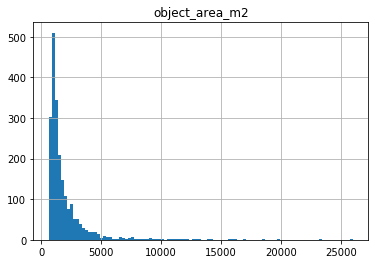

In [6]:
gdf_la = gdf.loc[gdf['NAME']=='Los Angeles']
gdf_la.crs = {'init': 'epsg:4326'}

## Show what built up change detection polygons look like
Let's look at change polgons in Los Angeles County

In [100]:
gdf_builtup = gpd.read_file(subscription_geojson)
gdf_builtup_la = gpd.sjoin(gdf_builtup, gdf_la, how="inner", op='intersects')

## What's the distribution of the change polygons by their size (area footprint)?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd76c113358>]],
      dtype=object)

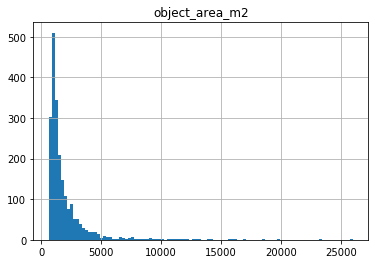

In [101]:
gdf_builtup_la.hist(column='object_area_m2', bins=100)

## Let's pick the large change polygons

In [102]:
gdf_builtup_la_filtered = gdf_builtup_la[gdf_builtup_la['object_area_m2'].between(1600.0, gdf_builtup_la['object_area_m2'].max())]
gdf_builtup_la_filtered.iloc[10]

id                                   181db4cf-f93f-4206-a93d-e6bfb9bf8a8e
label                                                            building
object_area_m2                                                    4343.06
observed                                              2019-06-01T00:00:00
source_last_acquired                                  2019-07-01T00:00:00
source_mosaic                                                        None
source_mosaic_name                          global_monthly_2019_06_mosaic
source_quad_id                                                   352-1228
geometry                POLYGON ((-118.116974814166 33.7883141990189, ...
index_right                                                            47
GEO_ID                                                     0500000US06037
STATE                                                                  06
COUNTY                                                                037
NAME                                  

In [138]:
def folium_county_change_detection_map(gdf):
    m = folium.Map([gdf.geometry.centroid.y.values[1], gdf.geometry.centroid.x.values[1]], zoom_start=9, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['AV_FIRE_THREAT']])

    from branca.colormap import linear

    colormap = linear.OrRd_09.scale(df.AV_FIRE_THREAT.min()-0.01, df.AV_FIRE_THREAT.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        style_function=lambda feature: {
            'fillColor': color_dict[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Average Risk'
    colormap.add_to(m)

    return m

folium_county_change_detection_map(gdf_builtup_la_filtered)

## Let's look at Cities within Los Angeles County

We want to load up region/city boundaries within Los Angeles County. We use the boundaries data set from https://hub.arcgis.com/datasets/7b0998f4e2ea42bda0068afc8eeaf904_19/data, convert the shape file to GeoJSON and then update it with zonal statistics from QGIS. We can now load the data to a geopandas dataframe

In [105]:
gdf_cities = gpd.read_file("./data/LA_County_City_Boundaries.geojson")

## What does the city level risk data look like?

In [112]:
print(gdf_cities.iloc[75])

OBJECTID                                                  44728
CITY                                                       None
CITY_ID                                                    None
CITY_TYPE                                                  City
CITY_NAME                                         Santa Clarita
CITY_LABEL                                        Santa Clarita
COLOR_CODE                                                    2
ABBR                                                       None
CITY_NO                                                      73
DESCRIPTN                                                  SCLR
URL                                       www.santa-clarita.com
PHONE                                                6612592489
OF_AREA_SM                                               52.317
FEAT_TYPE                                                  Land
COMMENT                                                    None
COLOR_EGIS                              

## Let's get change polygons to associate with city data

We would now like to learn where we say built up area in Los Angeles based on cities/regions boundaries. We do a second spatial join to secure an augmented built up dataset 

In [116]:
#gdf_builtup_la.drop('index_right', axis=1, inplace=True)
gdf_builtup_la_cities = gpd.sjoin(gdf_builtup_la, gdf_cities, how="inner", op='intersects')
print(gdf_builtup_la_cities.iloc[1000])

id                                   ed6c9f9a-e15e-42bd-8585-95944e779240
label                                                            building
object_area_m2                                                    905.253
observed                                              2019-06-01T00:00:00
source_last_acquired                                  2019-07-01T00:00:00
source_mosaic                                                        None
source_mosaic_name                          global_monthly_2019_06_mosaic
source_quad_id                                                   350-1228
geometry                POLYGON ((-118.332366926868 33.8445779905545, ...
GEO_ID                                                     0500000US06037
STATE                                                                  06
COUNTY                                                                037
NAME                                                          Los Angeles
LSAD                                  

## Let's find built up area in a specific city within the county

At this point we can even filter based on individual cities to zone in on specific districts but we are not going to do that right now. Here is just an illustrative example. Notice that we now have a bunch of columns, the result of multiple inner spatial joins leading to additive metadata

In [117]:
gdf_builtup_la_cities.loc[gdf_builtup_la_cities['CITY_NAME'] == 'Santa Clarita'].head(3)

id     label  object_area_m2  \
2061  617777b1-c4e8-408e-b590-1d2ffbe25be4  building      699.991808   
2062  650417f6-864b-4e42-9cb3-d351bc20a6bc  building     1081.094544   
2063  81d90367-39c4-4d69-b586-5270c7e586ad  building    18455.842959   

                 observed source_last_acquired source_mosaic  \
2061  2019-06-01T00:00:00  2019-07-01T00:00:00          None   
2062  2019-06-01T00:00:00  2019-07-01T00:00:00          None   
2063  2019-06-01T00:00:00  2019-07-01T00:00:00          None   

                 source_mosaic_name source_quad_id  \
2061  global_monthly_2019_06_mosaic       349-1232   
2062  global_monthly_2019_06_mosaic       349-1232   
2063  global_monthly_2019_06_mosaic       349-1232   

                                               geometry          GEO_ID  ...  \
2061  POLYGON ((-118.51330 34.35336, -118.51343 34.3...  0500000US06037  ...   
2062  POLYGON ((-118.52943 34.35360, -118.52952 34.3...  0500000US06037  ...   
2063  POLYGON ((-118.51042 34.35552, -118.51051 34.3...  0500000US06037  ...   

     COMMENT              COLOR_EGIS POPULATION    ShapeSTAre     ShapeSTLen  \
2061    None  Pink - RGB 255,190,232       None  1.973159e+09  352383.193058   
2062    None  Pink - RGB 255,190,232       None  1.973159e+09  352383.193058   
2063    None  Pink - RGB 255,190,232       None  1.973159e+09  352383.193058   

      _count_right  _sum_right      _mean     _stdev   _max  
2061      203646.0  14445547.0  70.934597  61.945627  128.0  
2062      203646.0  14445547.0  70.934597  61.945627  128.0  
2063      203646.0  14445547.0  70.934597  61.945627  128.0  

[3 rows x 46 columns]

## What does the aggregate fire risk distribution look like over cities in LA County?

Looking at the distribution of average risk across the different cities in Los Angeles county, we see a bimodal distribution with a few cities like West Hollywood having a very low risk and few like Santa Clarita and Palos Verdes having a very high risk index.

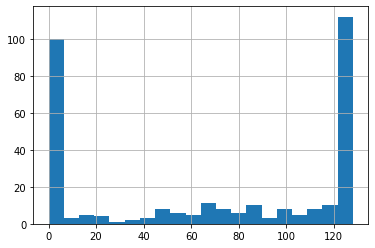

In [11]:
gdf_cities['_mean'].hist(bins=20)

Here is one representative data point, from a region in South Pasadena.

## What does the city data tell me?

In [12]:
gdf_cities.columns
gdf_cities.iloc[100]

OBJECTID                                                  44753
CITY                                                       None
CITY_ID                                                    None
CITY_TYPE                                                  City
CITY_NAME                                        South Pasadena
CITY_LABEL                                       South Pasadena
COLOR_CODE                                                    4
ABBR                                                       None
CITY_NO                                                      80
DESCRIPTN                                                  SPAS
URL                                 www.ci.south-pasadena.ca.us
PHONE                                                6264037200
OF_AREA_SM                                                3.468
FEAT_TYPE                                                  Land
COMMENT                                                    None
COLOR_EGIS                              

## Let's visualize aggregate risk at the city level

We also need to specify our colors, and I am doing this manually using branca linear color palettes  following brewer colors (https://github.com/ajdawson/colormaps/tree/master/lib/colormaps/palette/brewer/sequential) and the style attribute of our GeoDataFrame. The 'style' column is special, because folium will look for a column named 'style' to provide the the style attributes (similar to the 'geography' column). By default, the geometries that you get from the Census bureau are very detailed. This can cause problems loading in Chrome, so I use the geopandas simplify function to reduce the complexity of the geometries while still preserving the shape. Setting the tolerance takes a little trial and error, and in this particular example, I found that 0.001 worked well (a higher tolerance produces simpler geometry). By setting preserve_topology to False we can speed up the operation, and produce simpler geometries but could lead to gaps in between the polygons.

In [118]:
def folium_average_risk_detection_map(gdf):
    gdf['geometry'] = gdf['geometry'].simplify(0.0001, preserve_topology=True)

    centroid = gdf.geometry.centroid[1]
    m = folium.Map([centroid.y, centroid.x], zoom_start=8, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['_mean']])

    from branca.colormap import linear

    colormap = linear.OrRd_09.scale(df._mean.min(), df._mean.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        style_function=lambda feature: {
            'fillColor': color_dict[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Average Risk'
    colormap.add_to(m)

    return m

gdf = gpd.read_file("./data/LA_County_City_Boundaries.geojson")
m = folium_average_risk_detection_map(gdf)
m

## Let's aggregate built up count by cities and visualize

Getting to number of built up assets within each city/administrative region within the county normalized to the unit interval by dividing by the maximum number of change parcels

In [120]:
gdf_cities = gpd.read_file("./data/LA_County_City_Boundaries.geojson")
vc = gdf_builtup_la_cities['CITY_NAME'].value_counts().to_dict()
gdf_cities['built_count'] = gdf_cities.apply(lambda x: 0, axis=1)

max_count = max(vc.values())

for index, row in gdf_cities.iterrows():
    if row['CITY_NAME'] in list(vc.keys()):
        gdf_cities.loc[index, 'built_count'] = vc[row['CITY_NAME']]/max_count

In [124]:
def folium_builtup_count_map(gdf):
    gdf['geometry'] = gdf['geometry'].simplify(0.0001, preserve_topology=True)
    centroid=gdf.geometry.centroid[1]
    m = folium.Map([centroid.y,centroid.x], zoom_start=8, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['built_count']])

    from branca.colormap import linear
    colormap = linear.Purples_09.scale(df.built_count.min(), df.built_count.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        style_function=lambda feature: {
            'fillColor': color_dict[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Built Up Count'
    colormap.add_to(m)

    return m

gdf = gdf_cities
folium_builtup_count_map(gdf)

## What about spatial built up density?

Now let's acccumulate built up area over cities/administrative regions and see what that looks like, this indicative of the aggregate net new human settlement and commerical activity

In [125]:
built_area = dict()
for index, row in gdf_builtup_la_cities.iterrows():
    if row['CITY_NAME'] in list(built_area.keys()):
        built_area[row['CITY_NAME']] += row['object_area_m2']
    else:
        built_area.update({row['CITY_NAME']:row['object_area_m2']})

gdf_cities['built_area'] = gdf_cities.apply(lambda x: 0, axis=1)

max_built_area = max(built_area.values())

for index, row in gdf_cities.iterrows():
    if row['CITY_NAME'] in list(built_area.keys()):
        gdf_cities.loc[index, 'built_area'] = built_area[row['CITY_NAME']]/max_built_area

In [126]:
def folium_builtuparea_map(gdf):

    gdf['geometry'] = gdf['geometry'].simplify(0.0001, preserve_topology=True)
    centroid=gdf.geometry.centroid[1]
    m = folium.Map([centroid.y,centroid.x], zoom_start=8, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['built_area']])

    from branca.colormap import linear

    colormap = linear.YlOrRd_09.scale(df.built_area.min(), df.built_area.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(
        gdf.to_json(),
        style_function=lambda feature: {
            'fillColor': color_dict[feature['id']],
            'color': 'black',
            'weight': 1,
            'fillOpacity': 0.9,
        }
    ).add_to(m)

    colormap.caption = 'Built Up Density'
    colormap.add_to(m)

    return m

gdf = gdf_cities
folium_builtuparea_map(gdf)

## Bringing it together Human Activity in Fire Risk Areas

Getting a multi-layer folium plot with fire risk and built up area. The amount of built up area in Santa Clarita city, affected by the Castaic/SaddleRidge Fires in recent months is small relative to other areas.

In [127]:
def folium_multilayer_map(gdf):
    gdf['geometry'] = gdf['geometry'].simplify(0.001, preserve_topology=True)
    centroid=gdf.geometry.centroid[75]

    #tiles='stamentoner'
    m=folium.Map(location=[centroid.y, centroid.x], zoom_start=8, tiles='cartodbpositron')

    df=pd.DataFrame(gdf.loc[:,['built_area']])
    colormap = linear.Purples_09.scale(df.built_area.min(), df.built_area.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict = dict(zip(key, values))

    folium.GeoJson(gdf.to_json(),
                   name="Built Up Area",
                   style_function=lambda x: {"weight":2, 'color':'black','fillColor':color_dict[x['id']], 'fillOpacity':0.7},
                    ).add_to(m)

    colormap.add_to(m)

    df=pd.DataFrame(gdf.loc[:,['_mean']])
    colormap = linear.YlOrRd_09.scale(df._mean.min(), df._mean.max())

    key = [str(index) for index, item in df.iterrows()]
    a = [df[key].values for key in df.keys()]
    values = [colormap(x) for x in list(a[0])]
    color_dict1 = dict(zip(key, values))

    folium.GeoJson(gdf.to_json(),
                   name='Average Risk',
                   style_function=lambda x: {"weight":2, 'color':'black','fillColor':color_dict1[x['id']], 'fillOpacity':0.7},
                  ).add_to(m)


    colormap.add_to(m)

    folium.LayerControl(autoZIndex=False, collapsed=False).add_to(m)

    return m

gdf = gdf_cities
folium_multilayer_map(gdf)

## Let's get more granular on location: How about we look at fire risk at built up asset level?

This will require us to work with the raw fire risk raster file. To enable faster execution, we will load up a smaller risk file that has been clipped to cover all of Los Angeles County. 

In [128]:
risk_la = rasterio.open(root_folder + 'FireRisk_LosAngelesCounty_clip.tif')

In [129]:
gdf_builtup_la_filtered_reproj = gdf_builtup_la_cities.to_crs({'init': 'epsg:3310'})
# shape = [json.loads(gdf_builtup_la_filtered_reproj.to_json())['features'][0]['geometry']]
shape = []
for index in range(len(gdf_builtup_la_filtered_reproj)):
    gdf_builtup_la_filtered_reproj_slice = gdf_builtup_la_filtered_reproj[index:index+1]
    shape.extend([json.loads(gdf_builtup_la_filtered_reproj_slice.to_json())['features'][0]['geometry']])

## Let's get the max risk pixel over each built up asset

Here we use the mask function from the rasterio package to get the risk pixels for just a single built up change asset and then find the max risk pixel overlapping the asset.

In [130]:
builtup_fire_risk = []
for polygon in shape:
    #out_image, out_transform = rasterio.mask.mask(risk_la, shapes=[polygon], crop=True, invert=False)
    out_image, out_transform = mask(risk_la, shapes=[polygon], crop=True, invert=False)
    out_image[out_image == -128] = 0
    builtup_fire_risk.append(np.max(out_image))

## We can augment our built up change assets with this risk information

In [132]:
gdf_builtup_la_cities['fire_risk_index'] = builtup_fire_risk

## Let's filter change polygons with only medium to high fire risk

In [ ]:
gdf_builtup_la_cities_risk = gdf_builtup_la_cities[gdf_builtup_la_cities['fire_risk_index'].between(3.0, gdf_builtup_la_cities['fire_risk_index'].max())]

## Let's look at which counties have recent built up area in high fire risk areas?

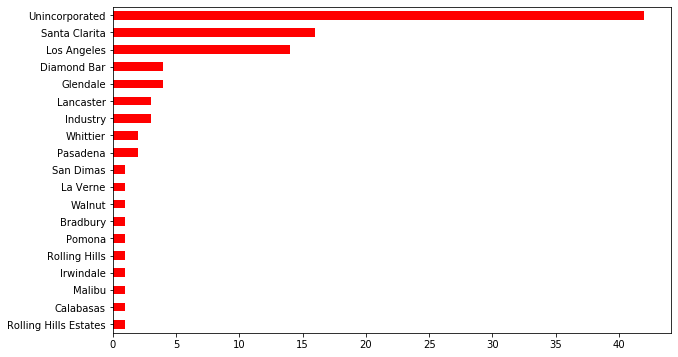

In [143]:
gdf_builtup_la_cities_risk['CITY_NAME'].value_counts().sort_values().plot(kind = 'barh', color = 'r', figsize=(10,6))